In [1]:
import pickle
import time
from IPython.display import clear_output
import sys
import os
import copy

import pandas as pd
import numpy as np
# %matplotlib inline
import matplotlib.pyplot as plt
import mpl_scatter_density
from tqdm import tqdm
from astropy.table import Table
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import DeepEnsemble
import metrics

In [2]:
data_dir = 'data/q_photo_z_train'
with open(f'{data_dir}/feature_lists/features_sdssdr16+all_deacls8tr_QSO+GALAXY_20201212143658.pkl', 'rb') as f:
    features_20 = pickle.load(f)
with open(f'{data_dir}/feature_lists/features_sdssdr16+psdr2+all_deacls8tr_QSO+GALAXY_20201212133711.pkl', 'rb') as f:
    features_35 = pickle.load(f)
with open(f'{data_dir}/feature_lists/features_deacls8tr_QSO+GALAXY_20201212135641.pkl', 'rb') as f:
    features_21 = pickle.load(f)
with open(f'{data_dir}/feature_lists/features_psdr2+all_deacls8tr_QSO+GALAXY_20201212142333.pkl', 'rb') as f:
    features_22 = pickle.load(f)
np.random.seed(2)
torch.manual_seed(2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
train_01 = pd.read_csv(f'{data_dir}/train_20_01.csv')
train_02 = pd.read_csv(f'{data_dir}/train_20_02.csv')

In [4]:
train_01.shape, train_02.shape

((288298, 92), (292158, 92))

In [5]:
train_01

,RA,DEC,Z,decals8tr_Lw1,decals8tr_Lw1-Lw2,decals8tr_Lw2,decals8tr_g,decals8tr_g-Lw1,decals8tr_g-Lw2,decals8tr_g-r,...,sdssdr16_z_cmodel-decals8tr_z,sdssdr16_z_psf,sdssdr16_z_psf-cmodel,max21_z,conf21_z,max22_z,conf22_z,max35_z,conf35_z,fold
0,170.455790,19.878579,-0.009112,19.606560,-0.592985,20.199544,19.441993,-0.164566,-0.757551,0.688502,...,-0.037778,18.425744,0.026430,2.498000,0.204978,0.100268,0.117886,3.230971,0.244179,1
1,18.832807,25.355562,-0.002058,20.385595,-0.869850,21.255445,19.100432,-1.285163,-2.155013,0.302125,...,-0.026118,18.721188,0.018640,1.459070,0.220922,1.552094,0.202644,2.388000,0.213741,1
2,340.711120,27.224917,-0.000798,25.333775,5.583276,19.750499,23.207197,-2.126578,3.456698,0.953378,...,-1.056814,21.029142,0.649879,1.815000,0.275649,0.457317,0.299660,1.489938,0.138860,1
3,184.390621,12.388094,-0.000515,19.394200,-0.214132,19.608331,20.193367,0.799168,0.585036,-0.103131,...,-6.233982,19.040828,4.697799,0.059143,0.150713,0.016712,0.167079,0.037960,0.279932,1
4,321.698292,-7.647149,-0.000503,21.393800,0.345580,21.048220,20.429209,-0.964591,-0.619011,0.434528,...,-0.086464,19.911721,0.140220,0.250512,0.083852,0.265134,0.106204,0.147753,0.086424,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288293,5.131124,-36.894948,6.834000,19.553581,-0.145996,19.699577,26.872133,7.318552,7.172555,1.077387,...,NaN,NaN,NaN,NaN,NaN,6.390070,0.383488,NaN,NaN,1
288294,41.732917,-52.330528,6.900000,20.298117,-0.100112,20.398229,26.798456,6.500339,6.400227,0.368550,...,NaN,NaN,NaN,NaN,NaN,6.123234,0.618998,NaN,NaN,1
288295,129.945333,39.003194,6.905000,19.109840,0.112651,18.997189,25.515129,6.405289,6.517940,-0.259710,...,NaN,NaN,NaN,2.243832,0.142105,6.377000,0.431664,NaN,NaN,1
288296,357.461364,6.252772,6.949000,18.987589,0.589668,18.397922,21.990789,3.003200,3.592867,0.985898,...,-0.187273,20.220181,0.107895,2.095132,0.363373,1.550000,0.523302,2.055263,0.320846,1


In [6]:
train_02

,RA,DEC,Z,decals8tr_Lw1,decals8tr_Lw1-Lw2,decals8tr_Lw2,decals8tr_g,decals8tr_g-Lw1,decals8tr_g-Lw2,decals8tr_g-r,...,sdssdr16_z_cmodel-decals8tr_z,sdssdr16_z_psf,sdssdr16_z_psf-cmodel,max21_z,conf21_z,max22_z,conf22_z,max35_z,conf35_z,fold
0,24.196261,-10.109838,-0.011447,19.960258,-0.137297,20.097554,19.708072,-0.252185,-0.389482,0.525462,...,-0.039920,18.921812,0.009676,0.050839,0.118156,0.087129,0.142408,0.076411,0.167270,2
1,184.240161,0.634044,-0.007947,19.350478,-0.636057,19.986535,18.620714,-0.729763,-1.365821,0.257748,...,-0.058617,18.306308,0.049146,0.151387,0.117320,0.055640,0.200341,0.112295,0.151217,2
2,122.091429,30.926546,-0.005114,21.271493,0.929939,20.341554,21.105814,-0.165679,0.764260,0.861072,...,0.031030,19.888133,0.057526,2.556220,0.221226,0.268127,0.130353,0.289233,0.102691,2
3,147.244138,27.849499,-0.000810,22.807423,1.597843,21.209581,21.861513,-0.945910,0.651933,0.067944,...,-2.930384,22.067579,3.063558,3.018800,0.710388,3.071691,0.646613,3.146000,0.719703,2
4,257.835533,37.789509,-0.000705,21.445772,-0.684682,22.130455,21.154559,-0.291213,-0.975895,0.691582,...,0.120755,20.312108,0.046655,0.250221,0.194149,0.229429,0.137957,1.807045,0.143804,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292153,129.407666,49.483444,6.710000,19.948461,0.635476,19.312985,25.340844,5.392383,6.027859,0.377814,...,NaN,NaN,NaN,0.906495,0.093949,6.200000,0.447981,NaN,NaN,2
292154,166.089958,21.574667,6.740000,19.919157,0.006301,19.912856,26.031365,6.112208,6.118510,-0.615328,...,NaN,NaN,NaN,2.236000,0.176007,6.654000,0.642608,NaN,NaN,2
292155,127.383208,41.294556,6.768000,20.104586,0.048389,20.056197,25.727275,5.622690,5.671078,-0.619201,...,NaN,NaN,NaN,1.823777,0.166808,6.663754,0.511770,NaN,NaN,2
292156,62.869291,-9.130500,6.810000,19.508455,0.136622,19.371833,26.801125,7.292670,7.429292,-0.936220,...,NaN,NaN,NaN,6.502475,0.348167,6.020939,0.486409,NaN,NaN,2


In [7]:
rf_features = ['max21_z', 'conf21_z', 'max22_z', 'conf22_z', 'max35_z', 'conf35_z',]

In [8]:
t_01 = train_01[['RA', 'DEC', 'Z'] + features_35 + rf_features].dropna().reset_index()
X_01 = t_01[features_35].values.astype(float)
y_01 = t_01['Z'].values.astype(float)

t_02 = train_02[['RA', 'DEC', 'Z'] + features_35 + rf_features].dropna().reset_index()
X_02 = t_02[features_35].values.astype(float)
y_02 = t_02['Z'].values.astype(float)

In [9]:
t_01.shape, t_02.shape

((286201, 75), (289975, 75))

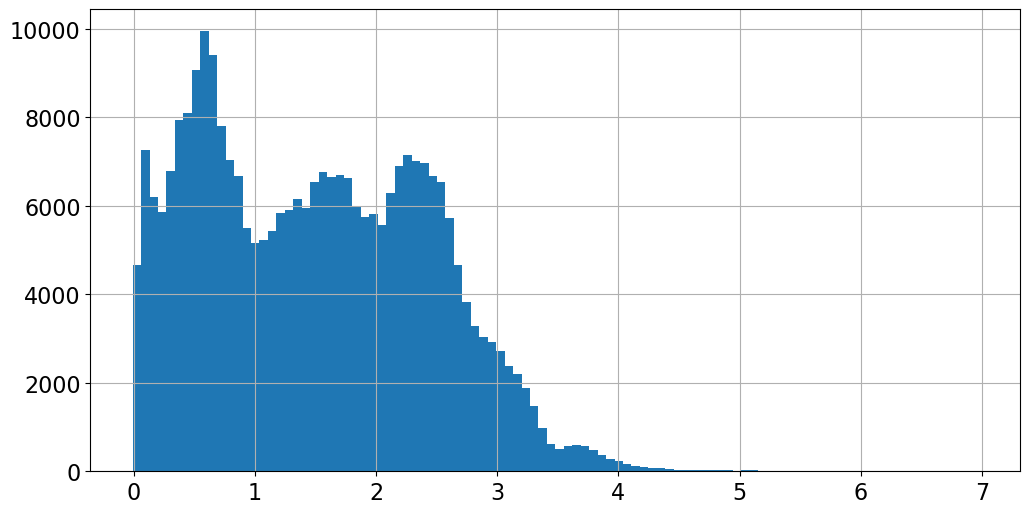

In [10]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 6))
plt.grid()
plt.hist(y_01, bins=100);

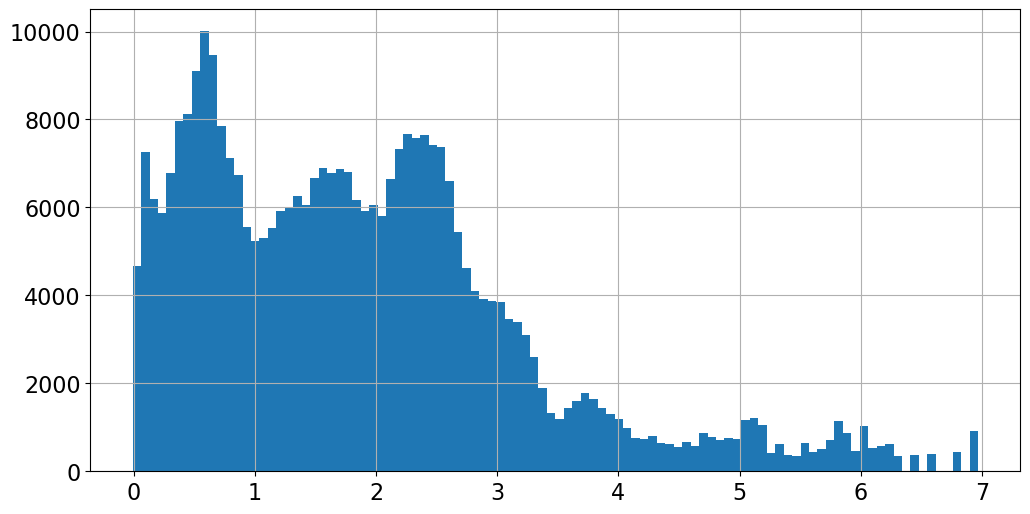

In [11]:
def p_func(z):
    return 1 / (1 + np.exp(-2.4*(z-6))) + 0.00002*np.exp((-6)*(z-1)**2) + 0.00002*np.exp((-3)*(z-2)**2)
n_dup = 500
z_thr = 4.5

dataloader = DeepEnsemble.HZ_dataloader_new(
    torch.tensor(X_01, device=torch.device(device), dtype=torch.float),
    torch.tensor(y_01, device=torch.device(device), dtype=torch.float), 
    p_func, n_dup, z_thr=5, batch_size=2**13, shuffle=False, device=device
)

font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 6))
plt.grid()
plt.hist(y_01[dataloader.all_idx.cpu().numpy()], bins=100);

Device: cuda
Test mode: True
EPOCH #70/70:
Learning rate: 5.98e-05
----------------------------------------
Trian losses: [-1.23551, -1.23539, -1.23848, -1.24563, -1.25769]
AVG train loss: -1.24254
Train S_nmad: 0.02018	Train out_rate: 0.02728	Train S_nmad_z5: 0.00797	Train out_rate_z5: 0.00438	
----------------------------------------
Test losses: [-1.07024, -1.04963, -1.03512, -1.04512, -1.04]
AVG test loss: -1.04802
Test S_nmad: 0.02626	Test out_rate: 0.03611	Test S_nmad_z5: 0.02207	Test out_rate_z5: 0.02857	
----------------------------------------
Time: 7.49


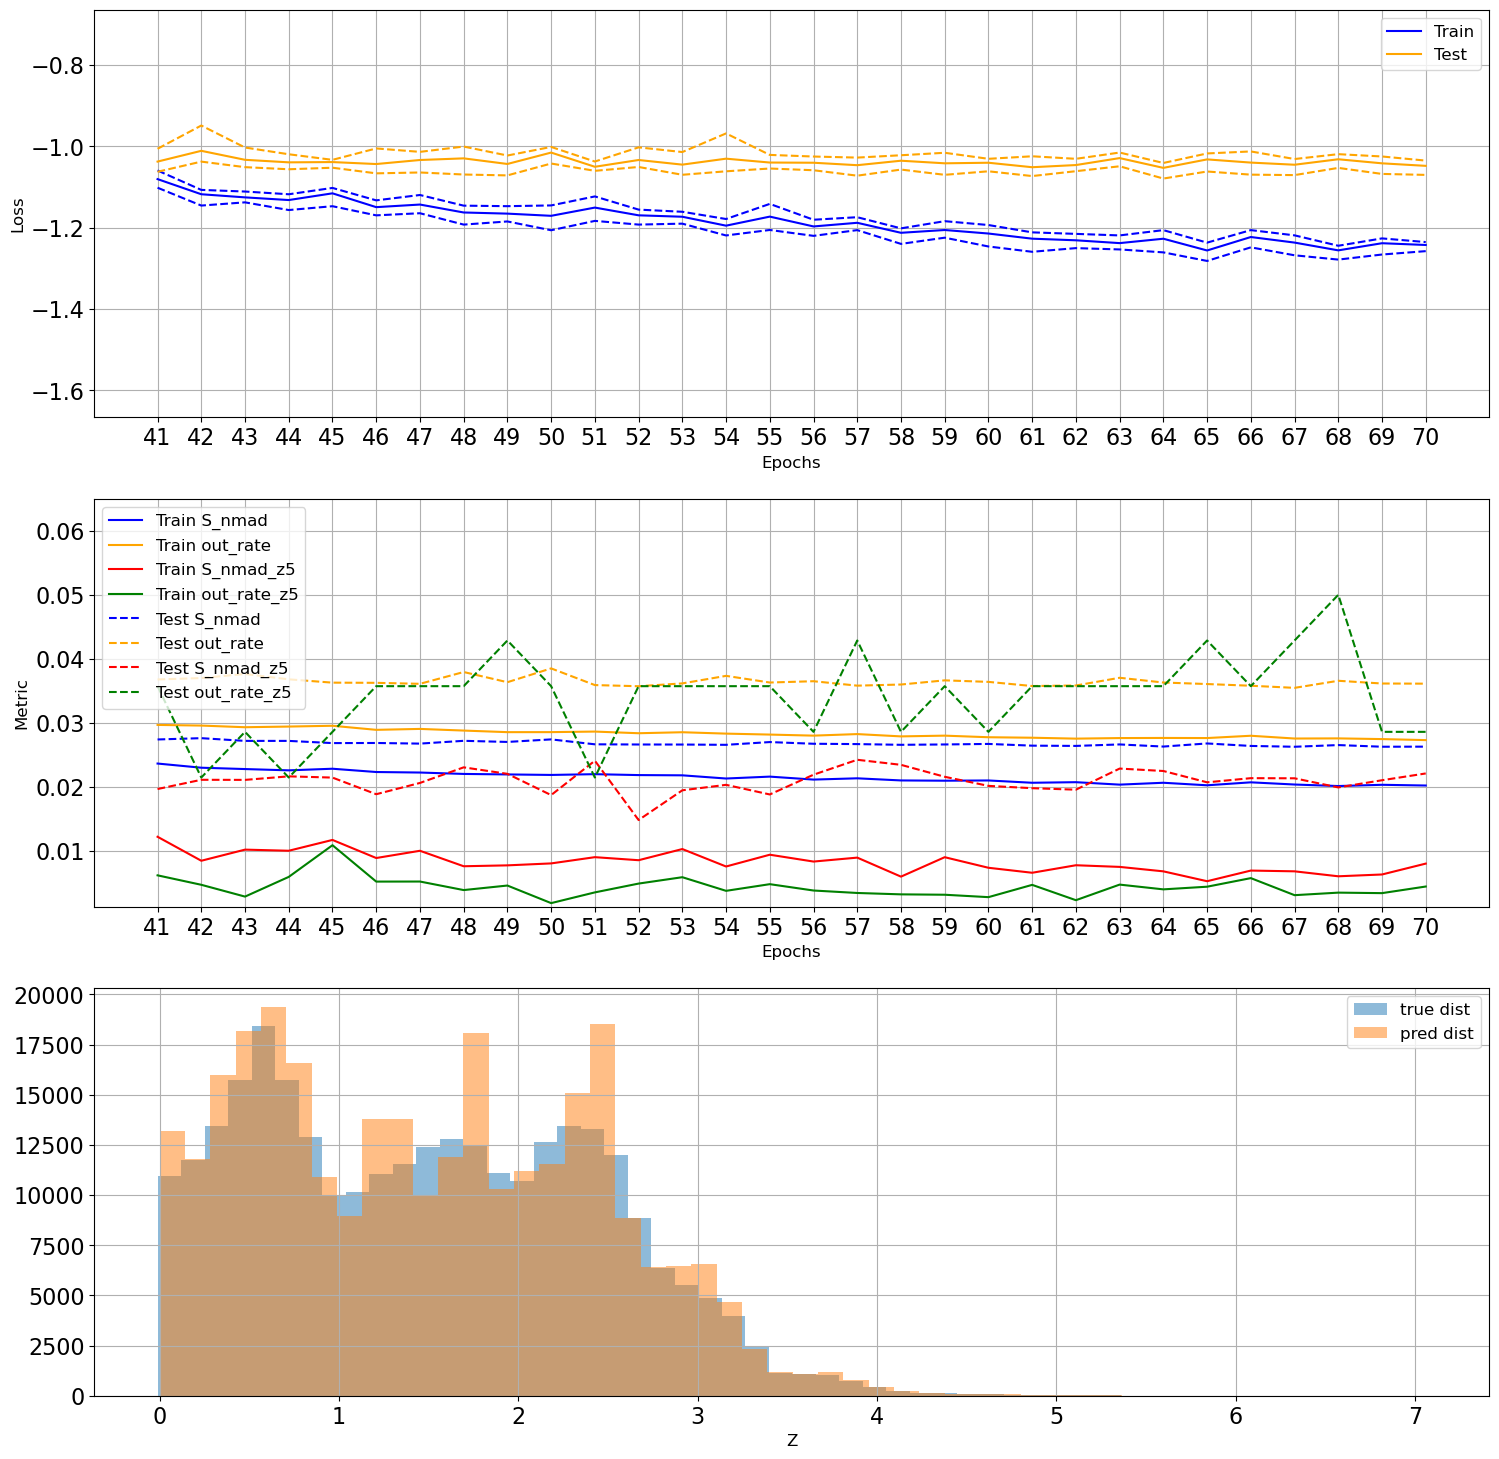

In [12]:
np.random.seed(1)
torch.manual_seed(1)

ens_35_01 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, 5], 'p': 0.0},
    5, device
)

X_train_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_35_01.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=70, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_35_01.save_pickle('ens_35_01_5models_05.pkl');

In [13]:
ens_35_01 = DeepEnsemble.DeepEnsemble_GMM.load_pickle('ens_35_01_5models_05.pkl')

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
result_35_02 = ens_35_01.predict(X_02)
result_35_02 = pd.concat([t_02[['RA', 'DEC', 'Z'] + features_35 + rf_features], result_35_02], axis=1)
result_35_02

(289975, 5)
(289975, 5)


,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,sample_279,sample_280,sample_281,sample_282,sample_283,sample_284,sample_285,sample_286,sample_287,zConf
0,24.196261,-10.109838,-0.011447,20.842147,19.756733,19.267105,19.053641,18.921812,20.784370,19.059832,...,-0.081700,1.202292,1.818763,3.637055,2.832004,0.483180,2.366308,2.741010,1.672804,0.118056
1,184.240161,0.634044,-0.007947,19.550209,18.671965,18.413090,18.318118,18.306308,19.526882,18.314960,...,2.072640,1.797455,2.172468,3.211470,0.080414,1.000240,0.358658,1.755281,0.689722,0.107639
2,122.091429,30.926546,-0.005114,22.468104,21.251481,20.282878,20.080934,19.888133,19.921550,19.986937,...,0.145226,3.091584,2.820586,0.761037,2.715081,0.206542,0.130636,3.158600,2.719521,0.187500
3,147.244138,27.849499,-0.000810,22.761290,21.715669,21.760738,21.599708,22.067579,21.701000,21.575285,...,3.087838,0.063383,2.958914,2.935430,2.386057,3.101767,2.956192,2.973601,2.874606,0.743056
4,257.835533,37.789509,-0.000705,24.357430,21.330316,20.575749,20.366500,20.312108,22.702280,20.404416,...,3.075289,3.039626,2.555163,3.088182,3.432435,3.756747,3.088651,1.872575,3.267358,0.454861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289970,177.013704,7.035635,6.339000,24.757579,25.072596,24.672193,23.667515,20.334672,24.789902,21.516479,...,5.843111,5.931034,6.168329,6.327551,5.259189,6.195796,5.329841,5.033992,5.434799,0.850694
289971,233.886958,19.722250,6.400000,24.374480,25.360028,24.768415,23.422782,20.834756,24.570427,22.676540,...,6.217873,6.353175,5.779968,5.902922,6.426033,6.445229,6.515427,6.159505,5.500404,0.621528
289972,177.069376,52.863999,6.418900,23.846045,24.953663,24.370246,23.232859,20.120725,21.661774,22.983385,...,6.236539,6.439159,6.383359,6.814752,6.271307,6.012118,5.970919,6.262437,5.041592,0.802083
289973,193.777745,47.962373,6.445232,24.572129,23.122277,21.751004,21.121208,20.348084,18.789576,20.244223,...,0.471988,0.541254,0.473261,0.493347,0.501258,0.823296,0.413552,0.500315,0.470310,0.875000


Device: cuda
Test mode: True
EPOCH #70/70:
Learning rate: 5.98e-05
----------------------------------------
Trian losses: [-1.24264, -1.25501, -1.28514, -1.27956, -1.22221]
AVG train loss: -1.25691
Train S_nmad: 0.02018	Train out_rate: 0.02837	Train S_nmad_z5: 0.00541	Train out_rate_z5: 0.0	
----------------------------------------
Test losses: [-1.06392, -1.05255, -1.03366, -1.04232, -1.03758]
AVG test loss: -1.04601
Test S_nmad: 0.02624	Test out_rate: 0.03578	Test S_nmad_z5: 0.01541	Test out_rate_z5: 0.08696	
----------------------------------------
Time: 6.939


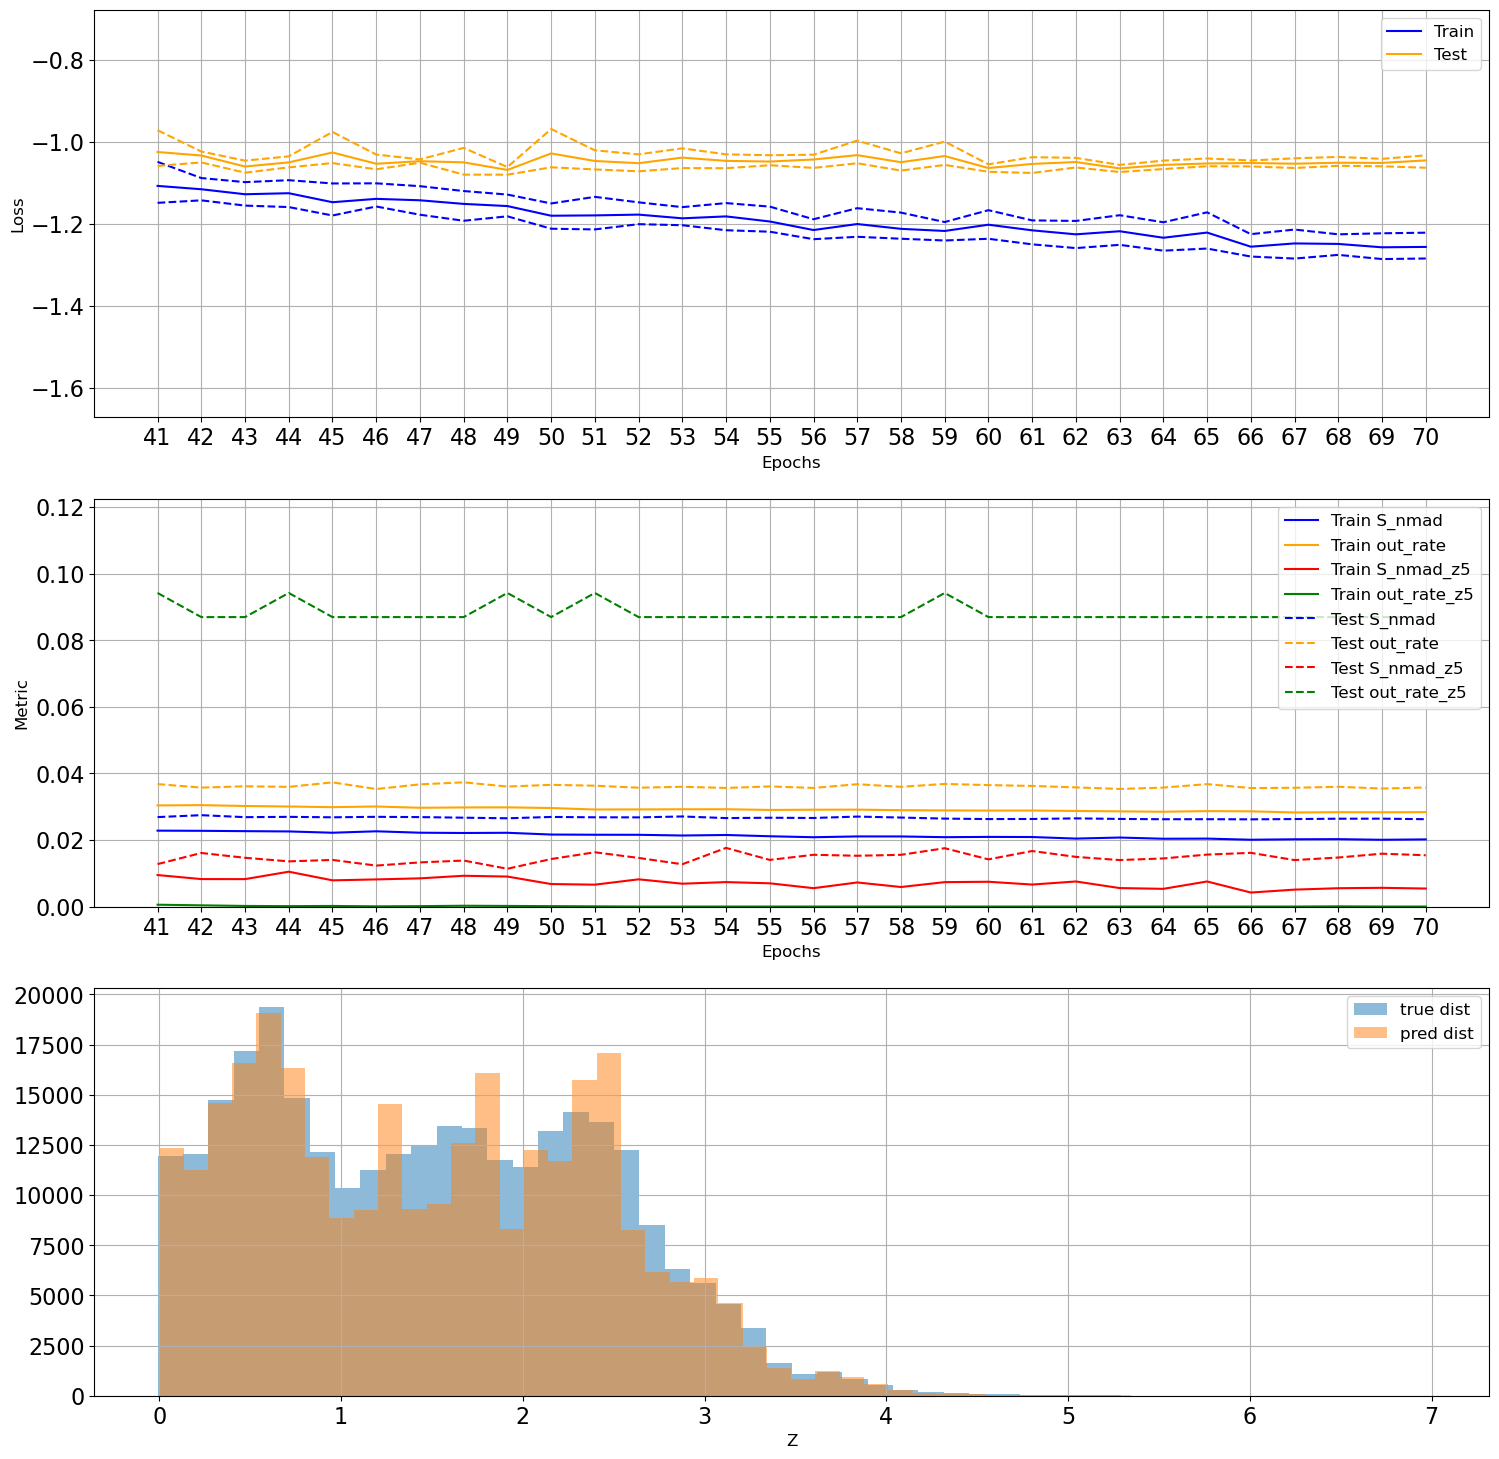

In [16]:
np.random.seed(1)
torch.manual_seed(1)

ens_35_02 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_02.shape[1], 400, 400, 400, 400, 400, 400, 5], 'p': 0.0},
    5, device
)

X_train_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_35_02.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=70, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);
ens_35_02.save_pickle('ens_35_02_5models_05.pkl');

In [17]:
ens_35_02 = DeepEnsemble.DeepEnsemble_GMM.load_pickle('ens_35_02_5models_05.pkl')

In [18]:
result_35_01 = ens_35_02.predict(X_01)
result_35_01 = pd.concat([t_01[['RA', 'DEC', 'Z'] + features_35 + rf_features], result_35_01], axis=1)
result_35_01

(286201, 5)
(286201, 5)


,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,sample_279,sample_280,sample_281,sample_282,sample_283,sample_284,sample_285,sample_286,sample_287,zConf
0,170.455790,19.878579,-0.009112,21.240596,19.528449,18.831749,18.584223,18.425744,21.187583,18.583677,...,-0.092869,2.251682,-0.200267,1.868497,2.440124,-0.142450,2.525968,0.593378,3.419030,0.118056
1,18.832807,25.355562,-0.002058,19.957126,19.084415,18.829452,18.737669,18.721188,19.828226,18.745945,...,3.145515,3.370100,3.094120,1.200111,3.087185,0.216860,1.282816,2.130993,2.327479,0.236111
2,340.711120,27.224917,-0.000798,24.037264,24.393690,24.110717,22.260261,21.029142,22.646628,21.899228,...,0.508646,0.150829,-0.940772,0.431374,1.312275,4.018828,2.944926,3.536873,1.885005,0.093750
3,184.390621,12.388094,-0.000515,19.156387,18.854721,18.870260,19.219621,19.040828,15.799093,14.392872,...,-0.006135,-0.004954,0.010084,-0.034484,-0.014254,-0.051048,-0.003752,-0.007151,-0.036933,0.993056
4,321.698292,-7.647149,-0.000503,21.643058,20.496566,20.066235,19.881459,19.911721,21.390054,19.870365,...,0.619963,0.234947,0.209556,0.566812,2.082111,0.086470,0.326183,4.663964,2.778371,0.118056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286196,247.297067,24.127706,6.476000,24.451345,23.685157,24.945349,24.295017,20.763244,24.446110,23.506013,...,6.903054,6.845887,6.580741,6.211926,6.545158,6.631376,6.251804,6.965392,6.574081,0.975694
286197,16.619326,18.475668,6.578712,21.326311,21.173190,20.940946,20.570890,19.888027,20.803366,20.449729,...,2.060161,2.030815,2.076803,2.037934,2.027398,2.053027,1.869043,1.986510,2.057989,0.982639
286198,174.891806,49.894562,6.795398,24.230143,24.980301,23.235294,22.281788,20.942590,20.276665,20.934541,...,0.419129,0.815225,0.712093,0.684676,0.856112,0.650099,0.769901,1.017241,0.806153,0.701389
286199,357.461364,6.252772,6.949000,22.151268,21.827504,21.142139,20.551375,20.220181,21.855427,20.521962,...,1.960294,1.608552,2.173976,1.652258,1.957088,1.504499,1.874419,2.064880,2.093607,0.552083


In [19]:
result_35_01['fold'] = [1] * result_35_01.shape[0]
result_35_02['fold'] = [2] * result_35_02.shape[0]

In [20]:
result_35 = pd.concat([result_35_01, result_35_02])
result_35.sort_values(by=['Z'], inplace=True)
result_35.reset_index(drop=True, inplace=True)
result_35

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,sample_280,sample_281,sample_282,sample_283,sample_284,sample_285,sample_286,sample_287,zConf,fold
0,24.196261,-10.109838,-0.011447,20.842147,19.756733,19.267105,19.053641,18.921812,20.784370,19.059832,...,1.202292,1.818763,3.637055,2.832004,0.483180,2.366308,2.741010,1.672804,0.118056,2
1,170.455790,19.878579,-0.009112,21.240596,19.528449,18.831749,18.584223,18.425744,21.187583,18.583677,...,2.251682,-0.200267,1.868497,2.440124,-0.142450,2.525968,0.593378,3.419030,0.118056,1
2,184.240161,0.634044,-0.007947,19.550209,18.671965,18.413090,18.318118,18.306308,19.526882,18.314960,...,1.797455,2.172468,3.211470,0.080414,1.000240,0.358658,1.755281,0.689722,0.107639,2
3,122.091429,30.926546,-0.005114,22.468104,21.251481,20.282878,20.080934,19.888133,19.921550,19.986937,...,3.091584,2.820586,0.761037,2.715081,0.206542,0.130636,3.158600,2.719521,0.187500,2
4,18.832807,25.355562,-0.002058,19.957126,19.084415,18.829452,18.737669,18.721188,19.828226,18.745945,...,3.370100,3.094120,1.200111,3.087185,0.216860,1.282816,2.130993,2.327479,0.236111,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576171,36.507807,3.049838,6.541200,24.312627,24.815416,24.377670,23.445890,20.656290,24.437056,21.850588,...,6.573350,6.366376,6.857126,5.847475,6.326244,6.011747,4.510083,6.733419,0.621528,2
576172,16.619326,18.475668,6.578712,21.326311,21.173190,20.940946,20.570890,19.888027,20.803366,20.449729,...,2.030815,2.076803,2.037934,2.027398,2.053027,1.869043,1.986510,2.057989,0.982639,1
576173,174.891806,49.894562,6.795398,24.230143,24.980301,23.235294,22.281788,20.942590,20.276665,20.934541,...,0.815225,0.712093,0.684676,0.856112,0.650099,0.769901,1.017241,0.806153,0.701389,1
576174,357.461364,6.252772,6.949000,22.151268,21.827504,21.142139,20.551375,20.220181,21.855427,20.521962,...,1.608552,2.173976,1.652258,1.957088,1.504499,1.874419,2.064880,2.093607,0.552083,1


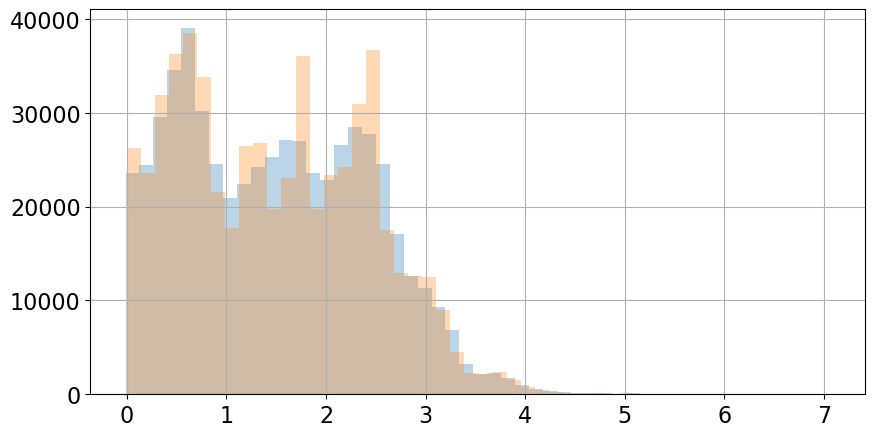

In [21]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 5))
# plt.xlim(0, 4)
plt.grid()

plt.hist(result_35['Z'], bins=50, alpha=0.3)
plt.hist(result_35['mode'], bins=50, alpha=0.3);

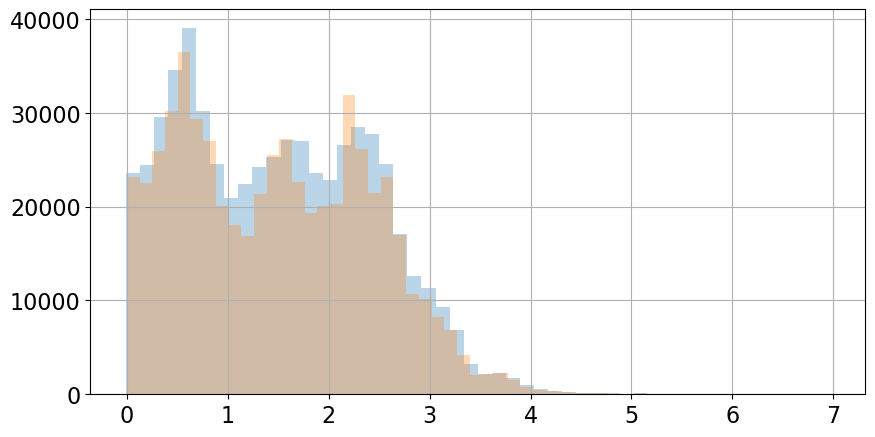

In [22]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 5))
# plt.xlim(0, 4)
plt.grid()

plt.hist(result_35['Z'], bins=50, alpha=0.3)
plt.hist(result_35['max35_z'], bins=50, alpha=0.3);

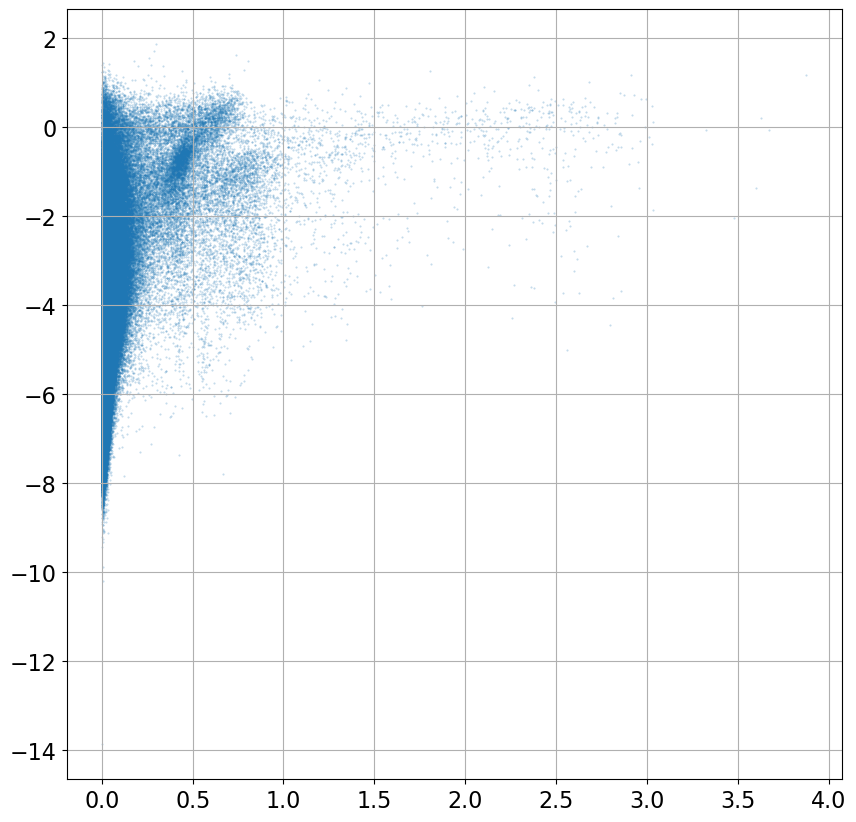

In [23]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.grid()

plt.scatter(np.abs((result_35['mode'] - result_35['Z']) / (1 + result_35['Z'])), np.log(result_35['sigma']), s=0.2, alpha=0.3)

Text(0.5, 1.0, 'NN 35')

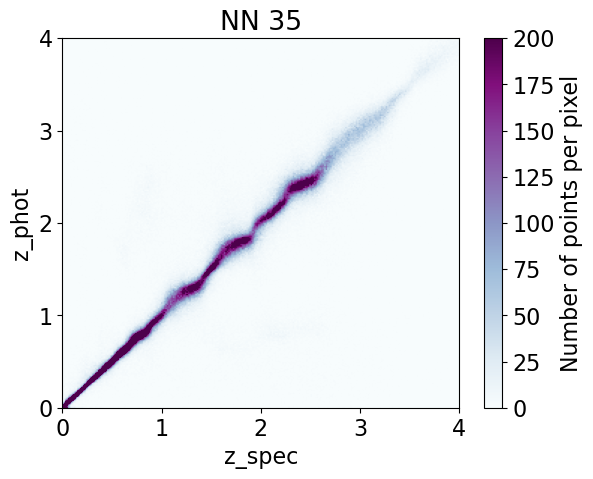

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density(result_35['Z'], result_35['mode'], vmin=0, vmax=200, cmap='BuPu')
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.set_xticks(range(5))
ax.set_yticks(range(5))
ax.set_xlabel('z_spec')
ax.set_ylabel('z_phot')
fig.colorbar(density, label='Number of points per pixel')
plt.title('NN 35')

Text(0.5, 1.0, 'RF')

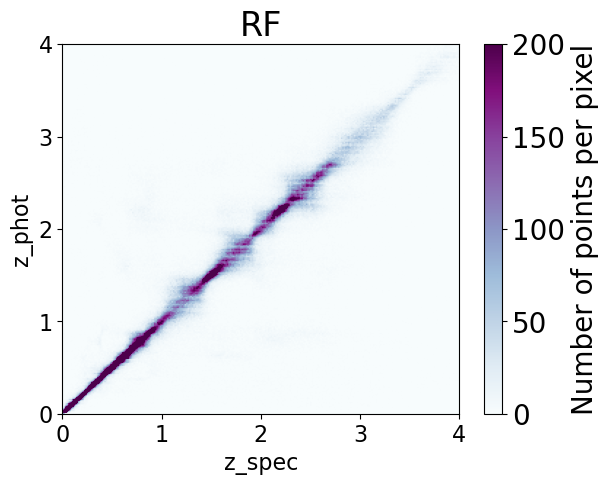

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density(result_35['Z'], result_35['max35_z'], vmin=0, vmax=200, cmap='BuPu')
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.set_xticks(range(5))
ax.set_yticks(range(5))
font = {'size': 20}
plt.rc('font', **font)
ax.set_xlabel('z_spec')
ax.set_ylabel('z_phot')
fig.colorbar(density, label='Number of points per pixel')
plt.title('RF')

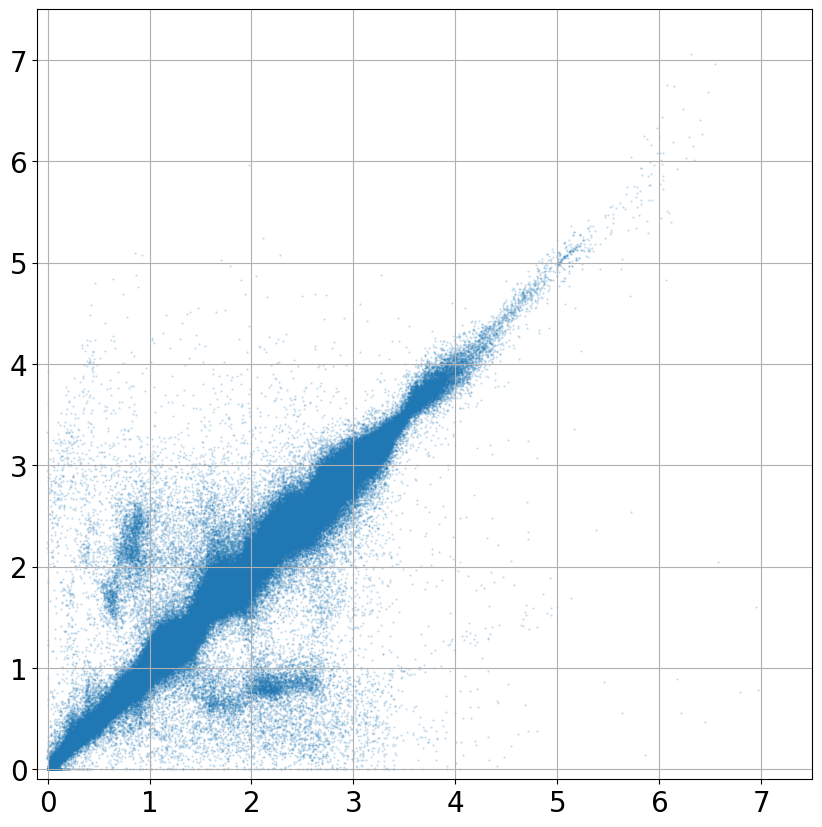

In [26]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 7.5))
plt.ylim((-0.1, 7.5))
plt.grid()

plt.scatter(result_35['Z'], result_35['mode'], s=0.2, alpha=0.3)

In [27]:
print(metrics.sigma_nmad(result_35['Z'], result_35['mode']))
print(metrics.out_rate(result_35['Z'], result_35['mode']))
print(metrics.sigma_nmad_z4(result_35['Z'], result_35['mode']))
print(metrics.out_rate_z4(result_35['Z'], result_35['mode']))
print(metrics.sigma_nmad_z5(result_35['Z'], result_35['mode']))
print(metrics.out_rate_z5(result_35['Z'], result_35['mode']))

0.026263858742099234
0.03591610896670462
0.02237879617275802
0.04983388704318937
0.020979667524201193
0.06115107913669065


In [28]:
print(metrics.sigma_nmad(result_35['Z'], result_35['max35_z']))
print(metrics.out_rate(result_35['Z'], result_35['max35_z']))
print(metrics.sigma_nmad_z4(result_35['Z'], result_35['max35_z']))
print(metrics.out_rate_z4(result_35['Z'], result_35['max35_z']))
print(metrics.sigma_nmad_z5(result_35['Z'], result_35['max35_z']))
print(metrics.out_rate_z5(result_35['Z'], result_35['max35_z']))

0.02807687797084618
0.048214434478353836
0.024063188339778507
0.08400569530137636
0.01701944900290227
0.12949640287769784


In [29]:
def step_metric(true, pred, z, step, metric):
    p = np.arange(z.min(), z.max()+0.001, step)
    values = []
    for i in range(len(p)):
        m = (z >= p[i]) & (z <= (p[i] + step))
        try:
            values.append(metric(true[m], pred[m]))
        except Exception:
            values.append(-1)
    return values, p

NameError: name 'p_nn_01' is not defined

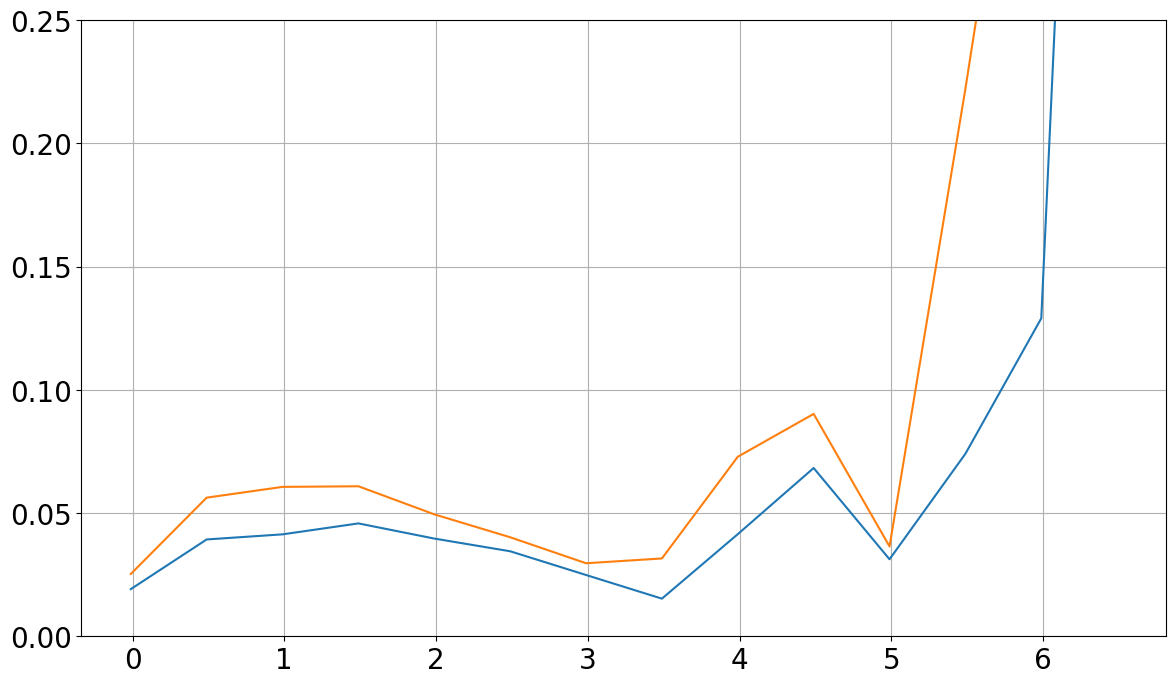

In [30]:
out_values_nn, p_nn = step_metric(result_35['Z'], result_35['mode'], result_35['Z'], 0.5, metrics.out_rate)
out_values_rf, p_rf = step_metric(result_35['Z'], result_35['max35_z'], result_35['Z'], 0.5, metrics.out_rate)

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(14, 8))
plt.ylim(0, 0.25)
plt.grid()

p_nn = np.array(p_nn)
p_rf = np.array(p_rf)
out_values_nn = np.array(out_values_nn)
out_values_rf = np.array(out_values_rf)

plt.plot(p_nn, out_values_nn, label='NN')
plt.plot(p_rf, out_values_rf, label='RF')
plt.plot(p_nn_01, out_values_nn_01_out[m], label='NN 1 gauss')
plt.plot(p_nn_01, out_values_nn_mse_out[m], label='NN mse')
plt.xlabel('Redshift')
plt.title('N > 0.15 (window size = 0.5)')
plt.legend()

In [ ]:
out_nn = (np.abs((result_35['Z'] - result_35['mode']) / (1 + result_35['Z'])) > 0.15).astype(int).values
sigma_nn = np.log(result_35['sigma'].values)
conf_nn = (-result_35['zConf']).values
out_rf = (np.abs((result_35['Z'] - result_35['max35_z']) / (1 + result_35['Z'])) > 0.15).astype(int).values
conf_rf = (-result_35['conf35_z']).values

In [ ]:
sigma_values_nn, sigma_p_nn = step_metric(out_nn, sigma_nn, result_35['Z'], 0.2, roc_auc_score)
conf_values_nn, conf_p_nn = step_metric(out_nn, conf_nn, result_35['Z'], 0.2, roc_auc_score)
conf_values_rf, conf_p_rf = step_metric(out_rf, conf_rf, result_35['Z'], 0.2, roc_auc_score)

font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(14, 8))
plt.grid()

plt.plot(sigma_p_nn, sigma_values_nn, label='sigma_NN')
plt.plot(conf_p_nn, conf_values_nn, label='conf_NN')
plt.plot(conf_p_rf, conf_values_rf, label='conf_RF')
plt.legend()

In [ ]:
m = (result_35['Z'] > -1).values

print(f'ROC-AUC NN SIGMA: {roc_auc_score(out_nn[m], sigma_nn[m])}')
print(f'ROC-AUC NN CONF: {roc_auc_score(out_nn[m], conf_nn[m])}')
print(f'ROC-AUC RF CONF: {roc_auc_score(out_rf[m], conf_rf[m])}')

fpr_sigma_nn, tpr_sigma_nn, thresholds_sigma_nn = roc_curve(out_nn[m], sigma_nn[m], pos_label=1)
fpr_conf_nn, tpr_conf_nn, thresholds_conf_nn = roc_curve(out_nn[m], conf_nn[m], pos_label=1)
fpr_conf_rf, tpr_conf_rf, thresholds_conf_rf = roc_curve(out_rf[m], conf_rf[m], pos_label=1)

font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.grid()

plt.plot(fpr_sigma_nn, tpr_sigma_nn, label='NN SIGMA')
plt.plot(fpr_conf_nn, tpr_conf_nn, label='NN CONF')
plt.plot(fpr_conf_rf, tpr_conf_rf, label='RF CONF')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend();

In [ ]:
prec_sigma_nn, recall_sigma_nn, thresholds_sigma_nn = precision_recall_curve(out_nn[m], sigma_nn[m], pos_label=1)
prec_conf_nn, recall_conf_nn, thresholds_conf_nn = precision_recall_curve(out_nn[m], conf_nn[m], pos_label=1)
prec_conf_rf, recall_conf_rf, thresholds_conf_rf = precision_recall_curve(out_rf[m], conf_rf[m], pos_label=1)

font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.grid()

plt.plot(prec_sigma_nn, recall_sigma_nn, label='NN SIGMA')
plt.plot(prec_conf_nn, recall_conf_nn, label='NN CONF')
plt.plot(prec_conf_rf, recall_conf_rf, label='RF CONF')
plt.xlabel('PREC')
plt.ylabel('RECALL')
plt.legend();